<a href="https://colab.research.google.com/github/Nashra-Tazmeen/-CNN-based-Potato-Disease-Diagnosis/blob/main/potatodisease_predictionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Create a directory named 'my_directory'
!mkdir my_directory


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set all the constants

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=15

Import data into tensorflow dataset object

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 2 0 1 0 2 1 0 0 0 1 1 0 1 0 0 1 1]


In [ ]:
print(image_batch[0].numpy())

[[[146. 141. 148.]
  [148. 143. 150.]
  [141. 136. 143.]
  ...
  [187. 184. 191.]
  [185. 182. 189.]
  [185. 182. 189.]]

 [[150. 145. 152.]
  [145. 140. 147.]
  [140. 135. 142.]
  ...
  [192. 189. 196.]
  [185. 182. 189.]
  [181. 178. 185.]]

 [[149. 144. 151.]
  [154. 149. 156.]
  [164. 159. 166.]
  ...
  [194. 191. 198.]
  [187. 184. 191.]
  [185. 182. 189.]]

 ...

 [[153. 151. 162.]
  [158. 156. 167.]
  [157. 155. 166.]
  ...
  [181. 180. 188.]
  [178. 177. 185.]
  [172. 171. 179.]]

 [[142. 140. 151.]
  [150. 148. 159.]
  [150. 148. 159.]
  ...
  [171. 170. 178.]
  [173. 172. 180.]
  [169. 168. 176.]]

 [[146. 144. 155.]
  [161. 159. 170.]
  [168. 166. 177.]
  ...
  [179. 178. 186.]
  [181. 180. 188.]
  [176. 175. 183.]]]


In [ ]:
print(image_batch[0].shape)

(256, 256, 3)


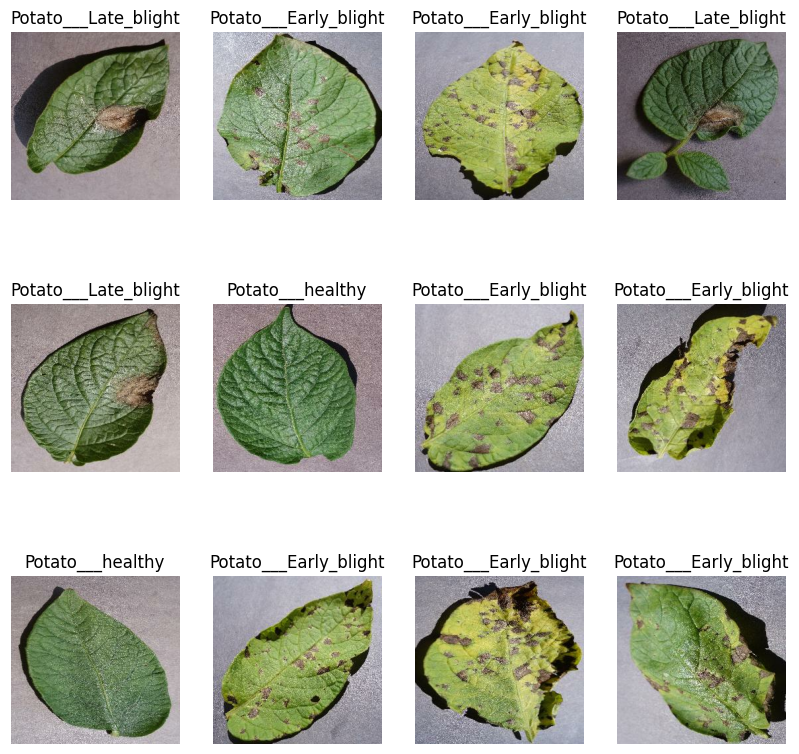

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
80% ==>training
20% ==>10% validation,10% test

SyntaxError: invalid syntax (<ipython-input-13-433c1e9312d7>, line 1)

In [ ]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds=dataset.take(54)

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

Cache shuffle and prefetch the data

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augumentation

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    ])

Applying Data Augumentation to train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
54/54 [==============================] - 22s 413ms/step - loss: 0.8944 - accuracy: 0.5295 - val_loss: 0.8444 - val_accuracy: 0.6458
Epoch 2/15
54/54 [==============================] - 15s 278ms/step - loss: 0.8036 - accuracy: 0.6082 - val_loss: 0.6022 - val_accuracy: 0.7656
Epoch 3/15
54/54 [==============================] - 15s 274ms/step - loss: 0.5689 - accuracy: 0.7760 - val_loss: 0.5927 - val_accuracy: 0.7604
Epoch 4/15
54/54 [==============================] - 15s 281ms/step - loss: 0.4840 - accuracy: 0.7969 - val_loss: 0.3922 - val_accuracy: 0.8333
Epoch 5/15
54/54 [==============================] - 15s 281ms/step - loss: 0.3880 - accuracy: 0.8356 - val_loss: 0.7486 - val_accuracy: 0.6823
Epoch 6/15
54/54 [==============================] - 15s 285ms/step - loss: 0.3308 - accuracy: 0.8681 - val_loss: 0.2913 - val_accuracy: 0.8646
Epoch 7/15
54/54 [==============================] - 15s 282ms/step - loss: 0.2651 - accuracy: 0.9028 - val_loss: 0.2914 - val_accuracy: 0.8854

In [ ]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 27ms/step - loss: 0.0650 - accuracy: 0.9844


In [ ]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.5295138955116272,
 0.6082175970077515,
 0.7760416865348816,
 0.796875,
 0.8356481194496155,
 0.8680555820465088,
 0.9027777910232544,
 0.9432870149612427,
 0.9577546119689941,
 0.9548611044883728,
 0.9658564925193787,
 0.9745370149612427,
 0.9803240895271301,
 0.9855324029922485,
 0.9907407164573669]

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8943957090377808,
 0.8035693764686584,
 0.568882167339325,
 0.4840226471424103,
 0.38804665207862854]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation Accuracy')

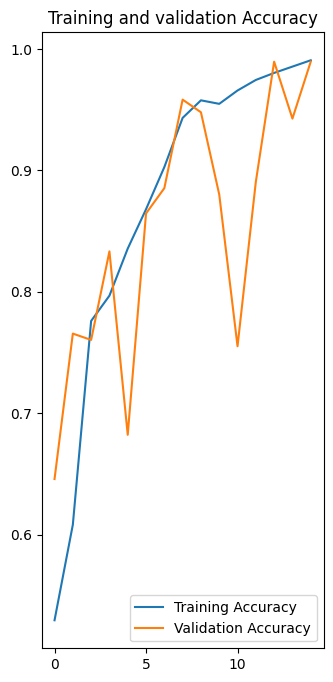

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

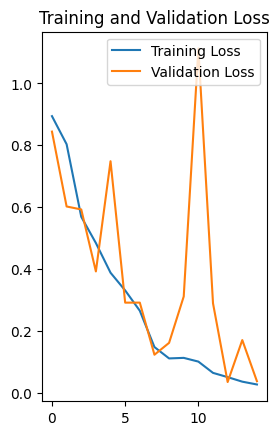

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

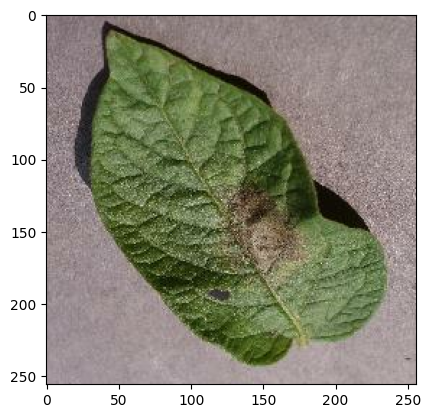

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  plt.imshow(images_batch[0].numpy().astype('uint8'))

Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 372ms/step
predicted label: Potato___Early_blight


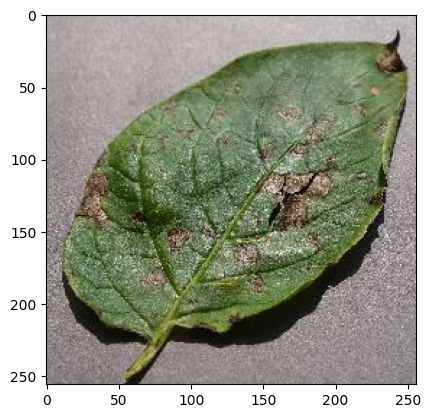

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Run inference on few sample images

1/1 [==============================] - 0s 18ms/step


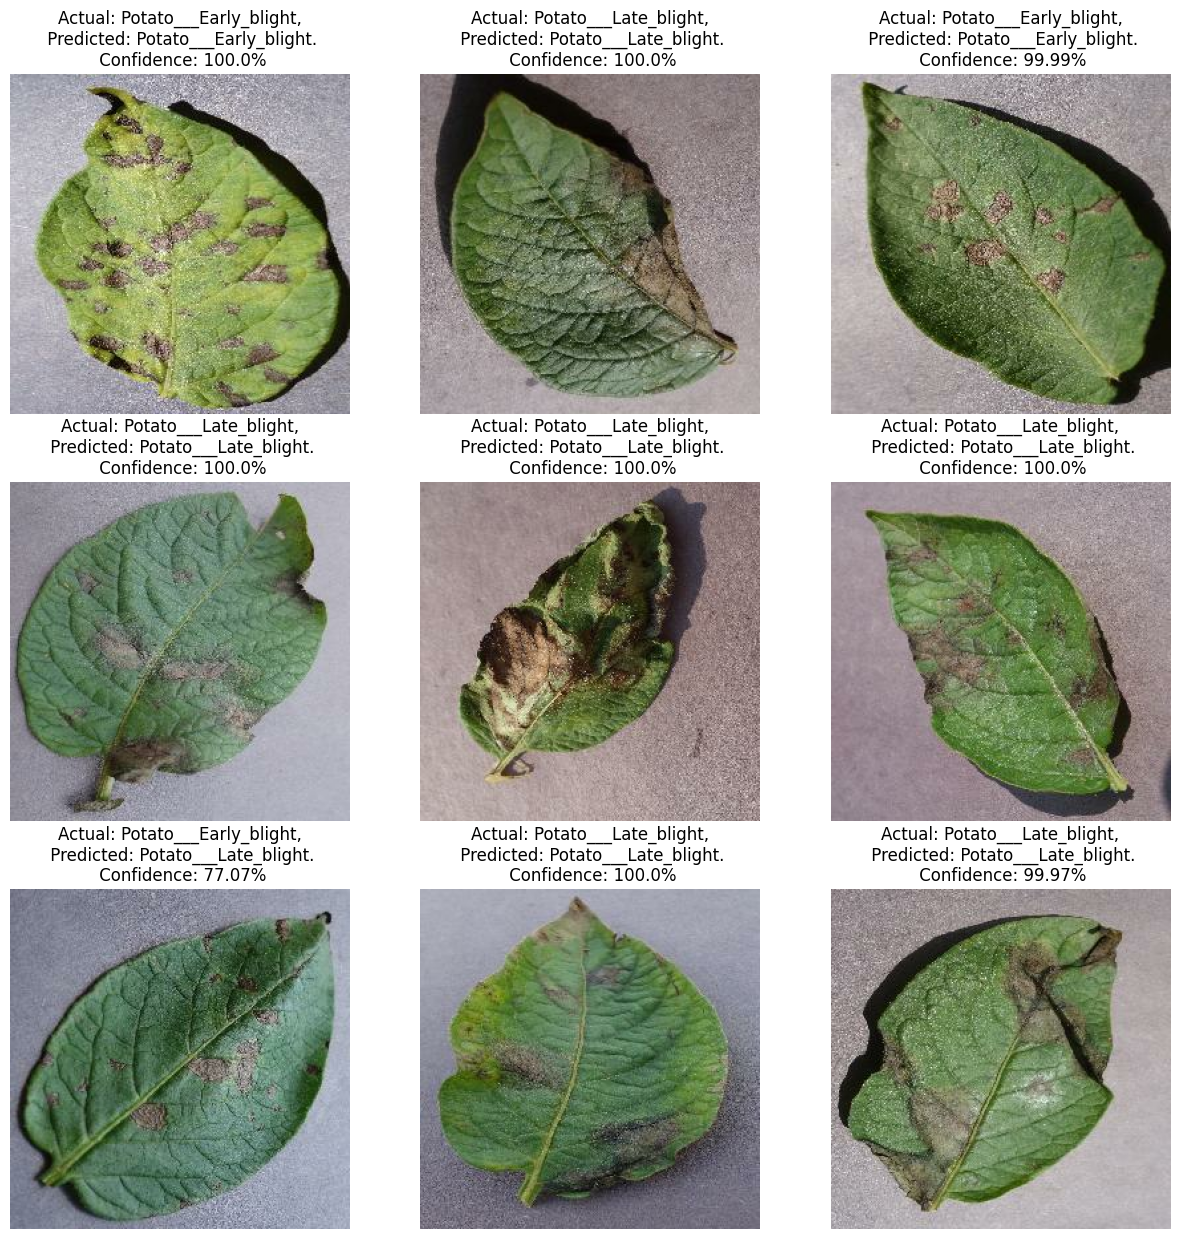

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
